# <font face = "optima"> Sentiment Semantic Learning <font>
@ Chen Jicheng  

## Data Acquisition and Storage  
ps: the following is not the given dataset, but the given dataset wiould be used at last section.

In [1]:
from datasets import load_dataset, load_from_disk
from pprint import pprint

In [2]:
save_path = "D:/跟课系列/2023年春/深度学习/My_work/陈纪程-2020110621-assignment-final/sst2"
# if you haven't load the dataset, please run the following code:
#  sst2_dataset = load_dataset("glue",name="sst2",cache_dir = save_path + "/load")
#  sst2_dataset.save_to_disk(save_path)
sst2_data = load_from_disk(save_path)

In [3]:
# stt2_data = sst2_data.shuffle()
# 注:使用shuffle()后的各个模型效果都会变差,更不稳定
pprint(sst2_data)

{'test': Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 1821
}),
 'train': Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
}),
 'validation': Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 872
})}


In [4]:
print("Two examples from the dataset using slice operation: \n")
print(sst2_data['train'][1])
print(sst2_data['test'][1])

Two examples from the dataset using slice operation: 

{'sentence': 'contains no wit , only labored gags ', 'label': 0, 'idx': 1}
{'sentence': "this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .", 'label': -1, 'idx': 1}


## Word to Vector, Sentence to Matrix

In [5]:
from collections import Counter
import torchtext.vocab as vocab
import numpy as np

# 1. 打开模型文件并读取所有行
# glove 为 torchtext库中的词向量模型,负责将词汇映射到高维空间中
# 模型下载请运行代码: glove = vocab.GloVe(name='6B', dim=50, cache=glove_path)
with open(save_path[0:-4]+"glove/glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()

# 2. 将每一行转化为一个单词和其对应的词向量表示，并存储在一个字典中
glove_dict = {}
for line in lines:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove_dict[word] = vector
    
# 3. 使用字典
word = 'i'
vector_example = glove_dict[word]
pprint(vector_example)

array([ 1.1891e-01,  1.5255e-01, -8.2073e-02, -7.4144e-01,  7.5917e-01,
       -4.8328e-01, -3.1009e-01,  5.1476e-01, -9.8708e-01,  6.1757e-04,
       -1.5043e-01,  8.3770e-01, -1.0797e+00, -5.1460e-01,  1.3188e+00,
        6.2007e-01,  1.3779e-01,  4.7108e-01, -7.2874e-02, -7.2675e-01,
       -7.4116e-01,  7.5263e-01,  8.8180e-01,  2.9561e-01,  1.3548e+00,
       -2.5701e+00, -1.3523e+00,  4.5880e-01,  1.0068e+00, -1.1856e+00,
        3.4737e+00,  7.7898e-01, -7.2929e-01,  2.5102e-01, -2.6156e-01,
       -3.4684e-01,  5.5841e-01,  7.5098e-01,  4.9830e-01, -2.6823e-01,
       -2.7443e-03, -1.8298e-02, -2.8096e-01,  5.5318e-01,  3.7706e-02,
        1.8555e-01, -1.5025e-01, -5.7512e-01, -2.6671e-01,  9.2121e-01],
      dtype=float32)


In [6]:
glove_dict["unentertaining"] = glove_dict["un"] + glove_dict["entertaining"]
# The only word can not be easily transformed into vector

In [7]:
import pandas as pd

sst2_train = pd.DataFrame(sst2_data["train"])
sst2_train.set_index(['idx'], inplace = True)
print(sst2_train)
sst2_test = pd.DataFrame(sst2_data["test"])
sst2_test.set_index(['idx'], inplace = True)
sst2_validation = pd.DataFrame(sst2_data["validation"])
sst2_validation.set_index(['idx'], inplace = True)

                                                sentence  label
idx                                                            
0           hide new secretions from the parental units       0
1                   contains no wit , only labored gags       0
2      that loves its characters and communicates som...      1
3      remains utterly satisfied to remain the same t...      0
4      on the worst revenge-of-the-nerds clichés the ...      0
...                                                  ...    ...
67344                               a delightful comedy       1
67345                   anguish , anger and frustration       0
67346  at achieving the modest , crowd-pleasing goals...      1
67347                                  a patient viewer       1
67348  this new jangle of noise , mayhem and stupidit...      0

[67349 rows x 2 columns]


The max length of sentence is:  56


<BarContainer object of 53 artists>

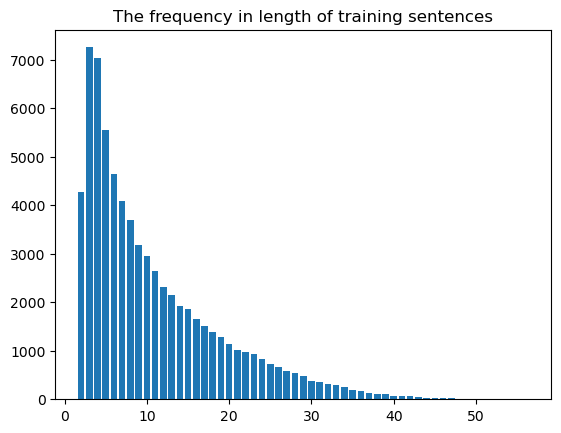

In [8]:
import matplotlib.pyplot as plt

max_words = 0
lengths = {}
for data_frame in [sst2_train, sst2_test, sst2_validation]:
    for i in range(data_frame.shape[0]):
        nwords = data_frame["sentence"][i].count(" ") + 1
        lengths[nwords] = lengths[nwords] + 1 if nwords in lengths.keys() else 1
        if max_words < nwords:
            max_words = nwords
print("The max length of sentence is: ",max_words)
plt.title("The frequency in length of training sentences")
plt.bar(lengths.keys(), [lengths[key] for key in lengths.keys()])

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# 借用 bert 的子词切分器

In [10]:
import nltk 
# 报错请运行本句: nltk.download('punkt', download_dir=save_path[0:-4] + "tokenizer")
nltk.data.path.append(save_path[0:-4] + "tokenizer")

#### <font size = 4 face = "Cambria Math">Generally using the glove_dict, but also use bert_tokenizer and stem_porter as assistances<font>

In [11]:
import re
from nltk.stem.porter import PorterStemmer
import torch
from sklearn.decomposition import PCA

def sentence_picture(sentence, max_seq_len):
    # return_type is numpy
    st = re.split("\s|-",sentence)
    if not all(st) in glove_dict.keys():
        for i in range(len(st)):
            word = st[i]
            if not st[i] in glove_dict.keys():
                if PorterStemmer().stem('word') in glove_dict.keys():
                    st[i] = PorterStemmer().stem('word')
                else:
                    words = tokenizer.tokenize(word)
                    st[i] = words
        new_st = []
        for words_word in st:
            if type(words_word) == list:
                for word in words_word:
                    word = re.sub('#', '', word)
                    new_st.append(word)
            else:
                new_st.append(words_word)
        st = new_st.copy()
    for i in range(len(st)):
        word = st[i]
        st[i] = glove_dict[word]
    st = np.asarray(st)
    if st.shape[0] > max_seq_len and max_seq_len <= st.shape[1]:
        st = np.transpose(st)
        st = PCA(n_components = max_seq_len).fit_transform(st)
        st = np.transpose(st)
    elif st.shape[0] > max_seq_len:
        raise Exception("Condition not satisfied:0< n_components< min(样本数，特征数),PCA is unable to decompose.")
    return st
    
def zip_st_pics(data_frame, max_seq_len, rand_padding = True):
    # return_type is tensor
    if not type(data_frame) == pd.core.frame.DataFrame:
        raise Exception("The function only cope with class: pandas.core.frame.DataFrame")
    st_pics = np.zeros([data_frame.shape[0],max_seq_len,50],dtype = np.float32)
    for idx in range(data_frame.shape[0]):
        st_pic = np.zeros([max_seq_len,50])
        sentence = data_frame["sentence"][idx]
        st = sentence_picture(sentence, max_seq_len)
        # 输出的句长已变为[2~max_seq_len]
        word_num = st.shape[0]
        if rand_padding:
            np.random.seed()
            index = np.random.randint(0,max_seq_len - word_num + 1)
        else:
            index = 0
        st_pic[index : index + word_num][:] = st
        st_pics[idx] = st_pic
    return torch.from_numpy(st_pics)
    

In [12]:
def tokenized_wordnums(dataset_list):
    max_words = 0
    lens_record = []
    for data_frame in dataset_list:
        len_stack = []
        for i in range(data_frame.shape[0]):
            st = sentence_picture(data_frame["sentence"][i], 1e5)
            nwords = st.shape[0]
            len_stack.append(nwords)
            if max_words < nwords:
                max_words = nwords
        lens_record.append(len_stack)
    print("The real max length of unfloded-sentence is: ", max_words)
    print("The real length of first 10 sentences in train_set:", lens_record[0][0:10])
    return max_words,lens_record

max_words,lens_record = tokenized_wordnums([sst2_train, sst2_test, sst2_validation])

The real max length of unfloded-sentence is:  58
The real length of first 10 sentences in train_set: [8, 8, 13, 9, 14, 11, 26, 3, 9, 14]


In [13]:
train_tensor = zip_st_pics(sst2_train, max_words, False).reshape(sst2_train.shape[0],max_words,50)
test_tensor = zip_st_pics(sst2_test, max_words, False).reshape(sst2_test.shape[0],max_words,50)
validation_tensor = zip_st_pics(sst2_validation, max_words, False).reshape(sst2_validation.shape[0],max_words,50)

train_tensor = train_tensor.reshape(sst2_train.shape[0],1,max_words,50)
test_tensor = test_tensor.reshape(sst2_test.shape[0],1,max_words,50)
validation_tensor = validation_tensor.reshape(sst2_validation.shape[0],1,max_words,50)
print(train_tensor.shape)

torch.Size([67349, 1, 58, 50])


In [14]:
train_label = torch.tensor([sst2_train['label'][idx] for idx in sst2_train.index])
validation_label = torch.tensor([sst2_validation['label'][idx] for idx in sst2_validation.index])
pprint(train_label)

tensor([0, 0, 1,  ..., 1, 1, 0])


## Semantic Recognition in CNN

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [16]:
# if you want to reshape again for another CNN training, you can run the following codes
'''
train_tensor = train_tensor.reshape(sst2_train.shape[0],1,max_words,50)
test_tensor = test_tensor.reshape(sst2_test.shape[0],1,max_words,50)
validation_tensor = validation_tensor.reshape(sst2_validation.shape[0],1,max_words,50)
'''

'\ntrain_tensor = train_tensor.reshape(sst2_train.shape[0],1,max_words,50)\ntest_tensor = test_tensor.reshape(sst2_test.shape[0],1,max_words,50)\nvalidation_tensor = validation_tensor.reshape(sst2_validation.shape[0],1,max_words,50)\n'

In [17]:
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

class SemanticCNN(nn.Module):
    def __init__(self):
        super(SemanticCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,16, (3,25), (1,5), padding = (1,0))
        self.conv2 = nn.Conv2d(16, 32, (3,6), 1, padding = (1,0))
        self.flatten = nn.Flatten(1,3)
        self.fc1 = nn.Linear(32*9*1, 8)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(8, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, kernel_size=(3,1), stride=(3,1))
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, kernel_size=(2,1), stride=(2,1))

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        output = x
        return output

# 初始化模型
model = SemanticCNN().to(device)
print(model)

# 选择合适的优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

SemanticCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 25), stride=(1, 5), padding=(1, 0))
  (conv2): Conv2d(16, 32, kernel_size=(3, 6), stride=(1, 1), padding=(1, 0))
  (flatten): Flatten(start_dim=1, end_dim=3)
  (fc1): Linear(in_features=288, out_features=8, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
)


In [18]:
max_epoch = 5
batch_size = 100

def train_CNN(model, train_tensor, train_label, optimizer, epoch):
    torch.manual_seed(1)
    global max_epoch
    global batch_size
    print("epoch:(%d/%d)" % (epoch, max_epoch))
    model.train()
    for batch_start in range(0, train_tensor.shape[0], batch_size):
        data, target = train_tensor[batch_start:min(batch_start + batch_size,train_tensor.shape[0])],\
            train_label[batch_start:min(batch_start + batch_size,train_tensor.shape[0])]

        # 清空之前轮次计算的梯度
        optimizer.zero_grad()

        # 前向传播得到预测结果
        output = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if (batch_start/batch_size) % 100 == 0:
            print('(%d/%d) loss: %f' % (batch_start/batch_size, (train_tensor.shape[0]//batch_size), loss.item()))

def test_CNN(model, test_tensor, test_label):
    model.eval()
    with torch.no_grad():
        data, target = test_tensor, test_label
        output = model(data)
        test_loss = loss_fn(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_tensor.shape[0],
        100. * correct / test_tensor.shape[0]))

for epoch in range(1, max_epoch + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_CNN(model, train_tensor, train_label, optimizer, epoch)
    test_CNN(model, validation_tensor, validation_label)

Epoch 1
-------------------------------
epoch:(1/5)
(0/673) loss: 0.694923
(100/673) loss: 0.560322
(200/673) loss: 0.557908
(300/673) loss: 0.510336
(400/673) loss: 0.504134
(500/673) loss: 0.454264
(600/673) loss: 0.434851

Test set: Average loss: 0.5368, Accuracy: 649/872 (74%)

Epoch 2
-------------------------------
epoch:(2/5)
(0/673) loss: 0.506065
(100/673) loss: 0.456608
(200/673) loss: 0.470803
(300/673) loss: 0.416812
(400/673) loss: 0.492803
(500/673) loss: 0.435320
(600/673) loss: 0.401955

Test set: Average loss: 0.5300, Accuracy: 676/872 (78%)

Epoch 3
-------------------------------
epoch:(3/5)
(0/673) loss: 0.451557
(100/673) loss: 0.422490
(200/673) loss: 0.475034
(300/673) loss: 0.404627
(400/673) loss: 0.506154
(500/673) loss: 0.415291
(600/673) loss: 0.405774

Test set: Average loss: 0.5378, Accuracy: 680/872 (78%)

Epoch 4
-------------------------------
epoch:(4/5)
(0/673) loss: 0.441960
(100/673) loss: 0.403207
(200/673) loss: 0.453087
(300/673) loss: 0.396068
(

#### <font size = 4 face = "Cambria Math">an example to see why the loss is boosted while accuaracy is higher<font>
    有一个样本预测输出是[0.1, 0.9], 它的交叉熵损失为loss = -1* log(0.9) = 0.046, 预测结果为：狗
    另一个样本的预测输出是[0.4, 0.6], 它的交叉熵损失为loss = -1 * log(0.6) = 0.222, 预测结果为：狗
    可以看出两个样本都预测的为狗，但是他们的交叉熵损失差别很大。因此我们在训练时，可能会出现准确率和交叉熵同时上升的情况。
    ————————————————
    版权声明：本文为CSDN博主「CVsaber」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
<a href="https://blog.csdn.net/u014421797/article/details/104689384" title="原文链接">原文链接</a>

In [19]:
path = "./model_save/Semantic CNN"
print(path)
#保存
torch.save(model.state_dict(), path)
#读取
CNN_model = SemanticCNN()
CNN_model.load_state_dict(torch.load(path))

./model_save/Semantic CNN


<All keys matched successfully>

In [20]:
CNN_model.eval()
test_output = CNN_model(test_tensor)
test_pre_1 = test_output.argmax(dim=1, keepdim=True)
validation_output = CNN_model(validation_tensor)
validation_pre_1 = validation_output.argmax(dim=1, keepdim=True)
pprint(test_pre_1)

tensor([[1],
        [0],
        [1],
        ...,
        [1],
        [1],
        [1]])


## Pack Padded Data ---- The Class Used latter

In [21]:
train_tensor = train_tensor.reshape(sst2_train.shape[0],max_words,50)
test_tensor = test_tensor.reshape(sst2_test.shape[0],max_words,50)
validation_tensor = validation_tensor.reshape(sst2_validation.shape[0],max_words,50)

In [22]:
example_batch = 10
train_pk_sq = nn.utils.rnn.pack_padded_sequence(
    input = train_tensor[0:example_batch],
    lengths = lens_record[0][0:example_batch],
    batch_first = True,
    enforce_sorted = False,
)
pprint(train_pk_sq)

PackedSequence(data=tensor([[ 0.1319,  0.1627, -0.6191,  ...,  0.9364, -0.1538,  0.4060],
        [ 0.3004,  0.2501, -0.1669,  ..., -0.0713,  0.2305, -0.5194],
        [ 0.9619,  0.0125,  0.2173,  ...,  0.1403, -0.3847, -0.3871],
        ...,
        [ 0.2789, -0.1845,  0.8661,  ..., -0.1348, -0.3713,  0.7045],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        [-0.1643,  0.1572, -0.5502,  ...,  0.7434,  0.2357, -0.1369]]), batch_sizes=tensor([10, 10, 10,  9,  9,  9,  9,  9,  7,  5,  5,  4,  4,  3,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1]), sorted_indices=tensor([6, 4, 9, 2, 5, 3, 8, 0, 1, 7]), unsorted_indices=tensor([7, 8, 3, 5, 1, 4, 0, 9, 6, 2]))


In [23]:
def same_sort(origin, unsorted_indices):
    new = origin.clone()
    for i in range(len(unsorted_indices)):
        new[i] = origin[unsorted_indices[i]]
    return new

new_label = same_sort(train_label[0:100],train_pk_sq.unsorted_indices)
print(all(same_sort(new_label,train_pk_sq.sorted_indices) == train_label[0:100]))

True


## Beter Sentiment Analysis in RNN

In [24]:
import torch.nn.utils.rnn as rnn_F

class SentimentRNN(nn.Module):
    def __init__(self, seq_len, hidden_size):
        super(SentimentRNN, self).__init__()
        self.seq_len = seq_len
        self.rnn = nn.GRU(50, hidden_size ,batch_first = True)
        self.cv = nn.Conv1d(seq_len, 12, 1, 1, 0)
        self.flatten = nn.Flatten(1,2)
        self.fc1 = nn.Linear(12*hidden_size, 8)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(8, 2)
        
    def forward(self, x, lengths):
        x = rnn_F.pack_padded_sequence(
            input = x,
            lengths = lengths,
            batch_first = True,
            enforce_sorted = False,
        )
        x,h = self.rnn(x)
        x,relens = rnn_F.pad_packed_sequence(
            x, 
            batch_first=True, 
            padding_value=0.0, 
            total_length=self.seq_len
        )
        
        x = self.cv(x)
        x = F.relu(x)
        
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        output = x
        return output,relens

hidden_size = 50
# 初始化模型
model = SentimentRNN(max_words, hidden_size).to(device)
print(model)

# 选择合适的优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)

SentimentRNN(
  (rnn): GRU(50, 50, batch_first=True)
  (cv): Conv1d(58, 12, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=2)
  (fc1): Linear(in_features=600, out_features=8, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
)


In [25]:
max_epoch = 5
batch_size = 100

def train_RNN(model, train_tensor, train_label, lens_record, optimizer, epoch):
    torch.manual_seed(1)
    global max_epoch
    global batch_size
    print("epoch:(%d/%d)" % (epoch, max_epoch))
    model.train()
    for batch_start in range(0, train_tensor.shape[0], batch_size):
        data, target = train_tensor[batch_start:min(batch_start + batch_size,train_tensor.shape[0])],\
            train_label[batch_start:min(batch_start + batch_size,train_tensor.shape[0])]
        lengths = lens_record[batch_start:min(batch_start + batch_size,train_tensor.shape[0])]
        
        # 清空之前轮次计算的梯度
        optimizer.zero_grad()

        # 前向传播得到预测结果
        output,relens = model(data, lengths)
        if any(relens != torch.tensor(lengths)):
            raise Exception("Something may be wrong in the model forward function.")

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if (batch_start/batch_size) % 100 == 0:
            print('(%d/%d) loss: %f' % (batch_start/batch_size, (train_tensor.shape[0]//batch_size), loss.item()))

def test_RNN(model, test_tensor, test_label, lens_record):
    model.eval()
    with torch.no_grad():
        data, target = test_tensor, test_label
        output, relens = model(data, lens_record)
        test_loss = loss_fn(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_tensor.shape[0],
        100. * correct / test_tensor.shape[0]))

for epoch in range(1, max_epoch + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_RNN(model, train_tensor, train_label, lens_record[0], optimizer, epoch)
    test_RNN(model, validation_tensor, validation_label, lens_record[2])

Epoch 1
-------------------------------
epoch:(1/5)
(0/673) loss: 0.693300
(100/673) loss: 0.528163
(200/673) loss: 0.479871
(300/673) loss: 0.491562
(400/673) loss: 0.465680
(500/673) loss: 0.468709
(600/673) loss: 0.414829

Test set: Average loss: 0.4765, Accuracy: 691/872 (79%)

Epoch 2
-------------------------------
epoch:(2/5)
(0/673) loss: 0.407401
(100/673) loss: 0.421536
(200/673) loss: 0.365150
(300/673) loss: 0.365971
(400/673) loss: 0.406671
(500/673) loss: 0.415008
(600/673) loss: 0.320738

Test set: Average loss: 0.5086, Accuracy: 705/872 (81%)

Epoch 3
-------------------------------
epoch:(3/5)
(0/673) loss: 0.309583
(100/673) loss: 0.349073
(200/673) loss: 0.333274
(300/673) loss: 0.274069
(400/673) loss: 0.444856
(500/673) loss: 0.360928
(600/673) loss: 0.309115

Test set: Average loss: 0.6250, Accuracy: 696/872 (80%)

Epoch 4
-------------------------------
epoch:(4/5)
(0/673) loss: 0.283334
(100/673) loss: 0.290959
(200/673) loss: 0.311858
(300/673) loss: 0.280024
(

In [26]:
path = "./model_save/Sentiment RNN"
print(path)
#保存
torch.save(model.state_dict(), path)
#读取
RNN_model = SentimentRNN(max_words, hidden_size)
RNN_model.load_state_dict(torch.load(path))

./model_save/Sentiment RNN


<All keys matched successfully>

In [27]:
RNN_model.eval()
test_output, relens = RNN_model(test_tensor, lens_record[1])
test_pre_2 = test_output.argmax(dim=1, keepdim=True)
validation_output, relens = RNN_model(validation_tensor, lens_record[2])
validation_pre_2 = validation_output.argmax(dim=1, keepdim=True)
print(sum(test_pre_2 == test_pre_1)/max(test_pre_1.shape))

tensor([0.7628])


## The RNN with Attention

In [28]:
class AttentionRNN(nn.Module):
    def __init__(self, seq_len, hidden_size_1, hidde_size_2, num_heads):
        super(AttentionRNN, self).__init__()
        self.seq_len = seq_len
        self.rnn = nn.GRU(50, hidden_size_1 ,batch_first = True)
        
        self.query = nn.Linear(hidden_size_1, hidden_size_2)
        self.key = nn.Linear(hidden_size_1, hidden_size_2)
        self.value = nn.Linear(hidden_size_1, hidden_size_2)
        self.multihead_attn = nn.MultiheadAttention(hidden_size_2, num_heads, dropout = 0.1, batch_first = True)
        
        self.flatten = nn.Flatten(1,2)
        self.fc = nn.Linear(seq_len*hidden_size_2, 2)
        
    def forward(self, x, lengths):
        x = rnn_F.pack_padded_sequence(
            input = x,
            lengths = lengths,
            batch_first = True,
            enforce_sorted = False,
        )
        x,h = self.rnn(x)
        x,relens = rnn_F.pad_packed_sequence(
            x, 
            batch_first=True, 
            padding_value=0.0, 
            total_length=self.seq_len
        )

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_output, attn_weights = self.multihead_attn(q, k, v)
        x = attn_output
        x = F.relu(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        
        output = x
        return output,relens

hidden_size_1 = 50
hidden_size_2 = 12
num_heads = 12
# 初始化模型
model = AttentionRNN(max_words, hidden_size_1, hidden_size_2, num_heads).to(device)
print(model)

AttentionRNN(
  (rnn): GRU(50, 50, batch_first=True)
  (query): Linear(in_features=50, out_features=12, bias=True)
  (key): Linear(in_features=50, out_features=12, bias=True)
  (value): Linear(in_features=50, out_features=12, bias=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=2)
  (fc): Linear(in_features=696, out_features=2, bias=True)
)


In [29]:
# 选择合适的优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
max_epoch = 6
batch_size = 100

for epoch in range(1, max_epoch + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_RNN(model, train_tensor, train_label, lens_record[0], optimizer, epoch)
    test_RNN(model, validation_tensor, validation_label, lens_record[2])

Epoch 1
-------------------------------
epoch:(1/6)
(0/673) loss: 0.693457
(100/673) loss: 0.587299
(200/673) loss: 0.508048
(300/673) loss: 0.416117
(400/673) loss: 0.432609
(500/673) loss: 0.374669
(600/673) loss: 0.407036

Test set: Average loss: 0.4639, Accuracy: 687/872 (79%)

Epoch 2
-------------------------------
epoch:(2/6)
(0/673) loss: 0.413637
(100/673) loss: 0.394494
(200/673) loss: 0.402105
(300/673) loss: 0.335213
(400/673) loss: 0.356800
(500/673) loss: 0.383554
(600/673) loss: 0.338467

Test set: Average loss: 0.4365, Accuracy: 699/872 (80%)

Epoch 3
-------------------------------
epoch:(3/6)
(0/673) loss: 0.381640
(100/673) loss: 0.344872
(200/673) loss: 0.332941
(300/673) loss: 0.278433
(400/673) loss: 0.336814
(500/673) loss: 0.394690
(600/673) loss: 0.295970

Test set: Average loss: 0.4355, Accuracy: 702/872 (81%)

Epoch 4
-------------------------------
epoch:(4/6)
(0/673) loss: 0.356789
(100/673) loss: 0.307147
(200/673) loss: 0.285467
(300/673) loss: 0.238465
(

In [30]:
path = "./model_save/Attention RNN"
print(path)
#保存
torch.save(model.state_dict(), path)
#读取
attRNN_model = AttentionRNN(max_words, hidden_size_1, hidden_size_2, num_heads)
attRNN_model.load_state_dict(torch.load(path))

./model_save/Attention RNN


<All keys matched successfully>

In [31]:
attRNN_model.eval()
test_output, relens = attRNN_model(test_tensor, lens_record[1])
test_pre_3 = test_output.argmax(dim=1, keepdim=True)
validation_output, relens = attRNN_model(validation_tensor, lens_record[2])
validation_pre_3 = validation_output.argmax(dim=1, keepdim=True)
print(sum(test_pre_3 == test_pre_2)/max(test_pre_2.shape))
print(sum(test_pre_3 == test_pre_1)/max(test_pre_1.shape))

tensor([0.8204])
tensor([0.8018])


## Conclusion and Implement on Given SST2

In [32]:
validation_pre = (validation_pre_3 + validation_pre_2 + validation_pre_1) >= 2
correct = validation_pre.eq(validation_label.view_as(validation_pre)).sum().item()
print("Accuracy in combination of the validation result:","{:.2%}".format(correct / validation_tensor.shape[0]))

Accuracy in combination of the validation result: 81.42%


In [33]:
test_pre = (test_pre_3 + test_pre_2 + test_pre_1) >= 2
print(sum(test_pre)/len(test_pre))
sst2_test['label'] = test_pre
pprint(sst2_test)
sst2_test.to_csv("./sst2_original_test_result.csv",sep=',',index=True,header=True)

tensor([0.5014])
                                               sentence  label
idx                                                           
0                uneasy mishmash of styles and genres .   True
1     this film 's relationship to actual tension is...  False
2     by the end of no such thing the audience , lik...   True
3     director rob marshall went out gunning to make...   True
4     lathan and diggs have considerable personal ch...   True
...                                                 ...    ...
1816  it risks seeming slow and pretentious , becaus...  False
1817  take care of my cat offers a refreshingly diff...   True
1818  davis has filled out his cast with appealing f...   True
1819  it represents better-than-average movie-making...  False
1820  dazzling and sugar-sweet , a blast of shallow ...   True

[1821 rows x 2 columns]


In [34]:
given_tr = pd.read_csv("./sst2/情感分类数据集-sst-2/sst-2/train.csv", low_memory = False)
given_ts = pd.read_csv("./sst2/情感分类数据集-sst-2/sst-2/test.csv", low_memory = False)
pprint(given_tr)

                                               sentence  label
0                                                  pig       0
1     you watch them clumsily mugging their way thro...      0
2                                      horrible poetry       0
3                               exceeds expectations .       1
4     beneath the film 's obvious determination to s...      1
...                                                 ...    ...
9995                                a fun family movie       1
9996  has the rare capability to soothe and break yo...      1
9997                                          is funny       1
9998  political prisoners , poverty and the boat loa...      0
9999  can be distinguished from a mediocre one by th...      1

[10000 rows x 2 columns]


In [35]:
max_words2, lens_record2 = tokenized_wordnums([given_tr, given_ts])

The real max length of unfloded-sentence is:  55
The real length of first 10 sentences in train_set: [2, 11, 3, 4, 23, 21, 6, 11, 8, 25]


In [36]:
train_tensor2 = zip_st_pics(given_tr, max_words, False).reshape(given_tr.shape[0],max_words,50)
test_tensor2 = zip_st_pics(given_ts, max_words, False).reshape(given_ts.shape[0],max_words,50)
print(train_tensor2.shape)
train_label2 = torch.tensor([given_tr['label'][idx] for idx in given_tr.index])
print(train_label2.shape)

torch.Size([10000, 58, 50])
torch.Size([10000])


#### <font size = 4 face = "Cambria Math">PS: 如果在给出数据集上表现不好, 再进一步训练<font>

In [37]:
CNN_model.eval()
train_output = CNN_model(train_tensor2.reshape(given_tr.shape[0],1,max_words,50))
train_pre_1 = train_output.argmax(dim=1, keepdim=True)

RNN_model.eval()
train_output, relens = RNN_model(train_tensor2, lens_record2[0])
train_pre_2 = train_output.argmax(dim=1, keepdim=True)

attRNN_model.eval()
train_output, relens = attRNN_model(train_tensor2, lens_record2[0])
train_pre_3 = train_output.argmax(dim=1, keepdim=True)

print(sum(train_pre_2 == train_pre_1)/max(train_pre_1.shape))
print(sum(train_pre_3 == train_pre_2)/max(train_pre_2.shape))
print(sum(train_pre_3 == train_pre_1)/max(train_pre_1.shape))

tensor([0.8667])
tensor([0.9153])
tensor([0.8710])


In [38]:
train_pre = (train_pre_3 + train_pre_2 + train_pre_1) >= 2
correct = train_pre.eq(train_label2.view_as(train_pre)).sum().item()
print("Accuracy in combination of the new train result:","{:.2%}".format(correct / train_tensor2.shape[0]))

Accuracy in combination of the new train result: 90.39%


#### <font size = 4 face = "Cambria Math">我们再回过头来对比一下被使用的训练集(loaded - not given sst2)上的准确率<font>  
不建议在普通电脑上使用原数据全集(含60000多条数据), 这会导致内存溢出错误

In [39]:
CNN_model.eval()
train_output = CNN_model(train_tensor[0:10000].reshape(10000,1,max_words,50))
train_pre_1 = train_output.argmax(dim=1, keepdim=True)

RNN_model.eval()
train_output, relens = RNN_model(train_tensor[0:10000], lens_record[0][0:10000])
train_pre_2 = train_output.argmax(dim=1, keepdim=True)

attRNN_model.eval()
train_output, relens = attRNN_model(train_tensor[0:10000], lens_record[0][0:10000])
train_pre_3 = train_output.argmax(dim=1, keepdim=True)

print(sum(train_pre_2 == train_pre_1)/max(train_pre_1.shape))
print(sum(train_pre_3 == train_pre_2)/max(train_pre_2.shape))
print(sum(train_pre_3 == train_pre_1)/max(train_pre_1.shape))

tensor([0.8677])
tensor([0.9085])
tensor([0.8672])


In [40]:
train_pre = (train_pre_3 + train_pre_2 + train_pre_1) >= 2
correct = train_pre.eq(train_label[0:10000].view_as(train_pre)).sum().item()
print("Accuracy in combination of the original train result:","{:.2%}".format(correct / 10000))

Accuracy in combination of the original train result: 90.00%


#### <font size = 4 face = "Cambria Math">由于新旧数据集的准确率非常相近 --- 不必进一步训练<font>

In [41]:
CNN_model.eval()
test_output = CNN_model(test_tensor2.reshape(given_ts.shape[0],1,max_words,50))
test_pre_1 = test_output.argmax(dim=1, keepdim=True)

RNN_model.eval()
test_output, relens = RNN_model(test_tensor2, lens_record2[1])
test_pre_2 = test_output.argmax(dim=1, keepdim=True)

attRNN_model.eval()
test_output, relens = attRNN_model(test_tensor2, lens_record2[1])
test_pre_3 = test_output.argmax(dim=1, keepdim=True)

In [42]:
test_pre = (test_pre_3 + test_pre_2 + test_pre_1) >= 2
print(sum(test_pre)/len(test_pre))
given_ts['label'] = test_pre
pprint(given_ts)
given_ts.to_csv("./SA_test_result.csv",sep=',',index=True,header=True)

tensor([0.5540])
                                              sentence  label
0                                         meaningless   False
1        solid , kinetically-charged spy flick worthy    True
2                                           strongest    True
3      do cliches , no matter how ` inside ' they are   False
4                       cleverly constructed scenario    True
..                                                 ...    ...
995                     jaw-droppingly beautiful work    True
996                  funny , ultimately heartbreaking    True
997  it 's been 13 months and 295 preview screening...  False
998  the art of getting laid in this prickly indie ...   True
999  ( seagal 's ) strenuous attempt at a change in...  False

[1000 rows x 2 columns]


# end